Download dataset from Kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wiratama03","key":"223e9c182ba3fdb19252a3dcb15ab029"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d trainingdatapro/gender-detection-and-classification-image-dataset

 98% 593M/606M [00:05<00:00, 152MB/s]
100% 606M/606M [00:05<00:00, 109MB/s]


Unzip datasets

In [7]:
!unzip gender-detection-and-classification-image-dataset.zip

Archive:  gender-detection-and-classification-image-dataset.zip
  inflating: gender_detection.csv    
  inflating: test/men/110.jpg        
  inflating: test/men/111.jpg        
  inflating: test/men/112.jpg        
  inflating: test/men/113.jpg        
  inflating: test/men/114.jpg        
  inflating: test/men/115.jpg        
  inflating: test/men/116.jpg        
  inflating: test/men/117.jpg        
  inflating: test/men/118.jpg        
  inflating: test/men/119.jpg        
  inflating: test/men/120.jpg        
  inflating: test/men/121.jpg        
  inflating: test/men/122.jpg        
  inflating: test/men/123.jpg        
  inflating: test/men/124.jpg        
  inflating: test/men/125.jpg        
  inflating: test/men/126.jpg        
  inflating: test/men/127.jpg        
  inflating: test/men/128.jpg        
  inflating: test/men/129.jpg        
  inflating: test/men/130.jpg        
  inflating: test/men/131.jpg        
  inflating: test/men/132.jpg        
  inflating: test/men/13

Import Library

In [152]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2

In [9]:
training_dir = "/content/train"
validation_dir = "/content/test"

Preview Datasets

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    shuffle=True,
    batch_size=32,
    image_size=(224, 224)
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    batch_size=32,
    image_size=(224, 224)
)

Found 220 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


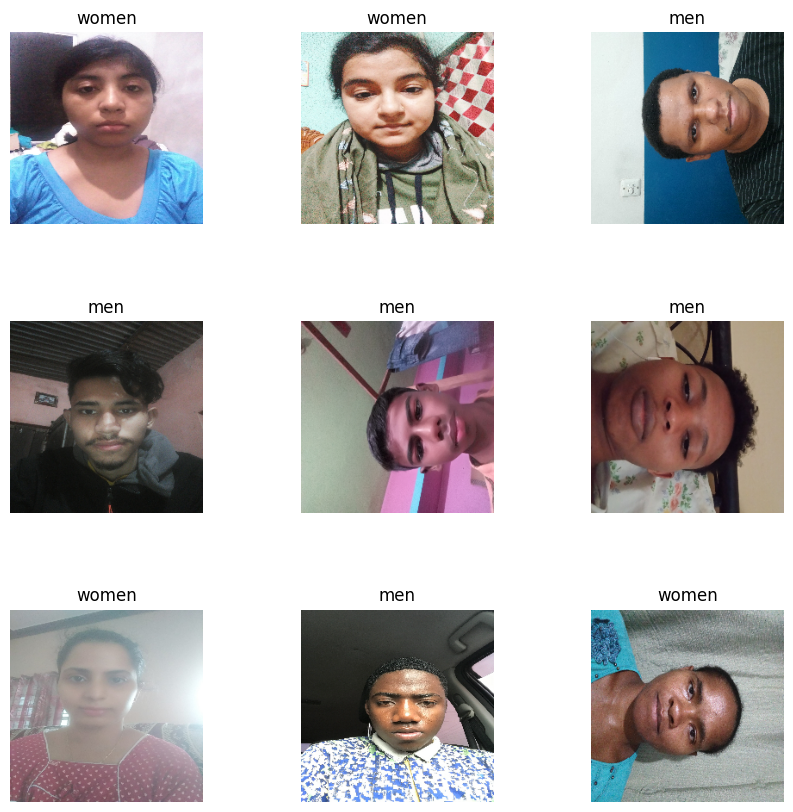

In [11]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Augmenting Datasets

In [267]:
def augmenting(training_dir, validation_dir):
  train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    brightness_range=[0.5,1.0]
  )
  validation_datagen=ImageDataGenerator(
      rescale=1.0/255.0
  )

  train_gen = train_datagen.flow_from_directory(
      directory=training_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )
  val_gen = validation_datagen.flow_from_directory(
      directory=validation_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )

  return train_gen, val_gen

In [268]:
train_gen, val_gen = augmenting(training_dir, validation_dir)

Found 220 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [221]:
class_label=train_gen.class_indices
print(class_label)

{'men': 0, 'women': 1}


Printing labels

In [15]:
with open('labels.txt', 'w') as file:
    for class_name in sorted(class_label, key=class_label.get):
        file.write(class_name + '\n')

Defining base model

In [222]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [223]:
base_model.trainable = False

In [224]:
train_gen.image_shape

(224, 224, 3)

create model

In [269]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_147 (Dense)           (None, 512)               655872    
                                                                 
 dropout_41 (Dropout)        (None, 512)               0         
                                                                 
 dense_148 (Dense)           (None, 256)               131328    
                                                                 
 dropout_42 (Dropout)        (None, 256)             

In [232]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.81 and logs.get('val_accuracy') > 0.81:
      self.model.stop_training = True

In [270]:
callback = modelCallback()
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.binary_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history=model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=callback)

Epoch 1/20
7/7 [==============================] - 44s 6s/step - loss: 0.7284 - accuracy: 0.5273 - val_loss: 0.5890 - val_accuracy: 0.7125
Epoch 2/20
7/7 [==============================] - 39s 6s/step - loss: 0.6143 - accuracy: 0.7091 - val_loss: 0.5417 - val_accuracy: 0.7000
Epoch 3/20
7/7 [==============================] - 37s 5s/step - loss: 0.4774 - accuracy: 0.7864 - val_loss: 0.5956 - val_accuracy: 0.7125
Epoch 4/20
7/7 [==============================] - 39s 6s/step - loss: 0.4248 - accuracy: 0.8045 - val_loss: 0.4900 - val_accuracy: 0.7375
Epoch 5/20
7/7 [==============================] - 46s 7s/step - loss: 0.4483 - accuracy: 0.8045 - val_loss: 0.4247 - val_accuracy: 0.7750
Epoch 6/20
7/7 [==============================] - 36s 5s/step - loss: 0.4258 - accuracy: 0.8091 - val_loss: 0.4427 - val_accuracy: 0.7500
Epoch 7/20
7/7 [==============================] - 36s 6s/step - loss: 0.3456 - accuracy: 0.8500 - val_loss: 0.4114 - val_accuracy: 0.8125
Epoch 8/20
7/7 [==================

review accuracy

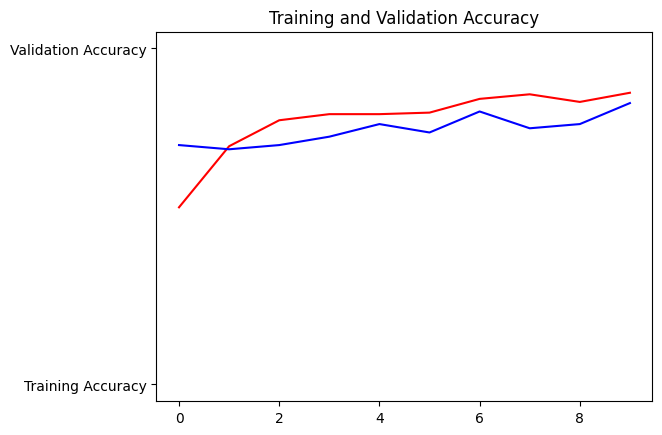

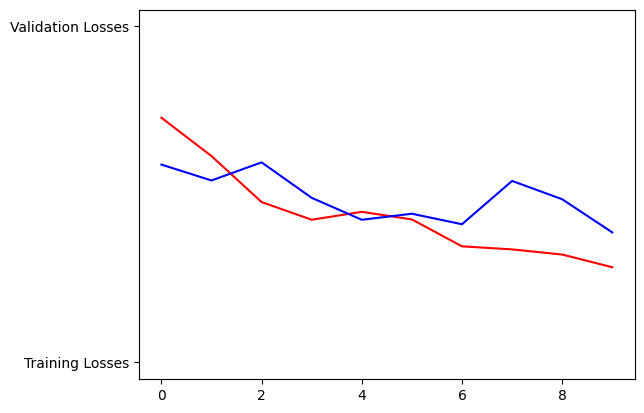

In [271]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

In [272]:
validation_results = model.evaluate(val_gen)

print("Validation Loss: {:.1f}%".format(validation_results[0] * 100))
print("Validation Accuracy: {:.1f}%".format(validation_results[1] * 100))

predictions = model.predict(val_gen)
# Check the shape of the predictions
print("Shape of predictions:", predictions.shape)

3/3 [==============================] - 11s 2s/step - loss: 0.3872 - accuracy: 0.8375
Validation Loss: 38.7%
Validation Accuracy: 83.7%
3/3 [==============================] - 11s 3s/step
Shape of predictions: (80, 2)


3/3 [==============================] - 10s 2s/step


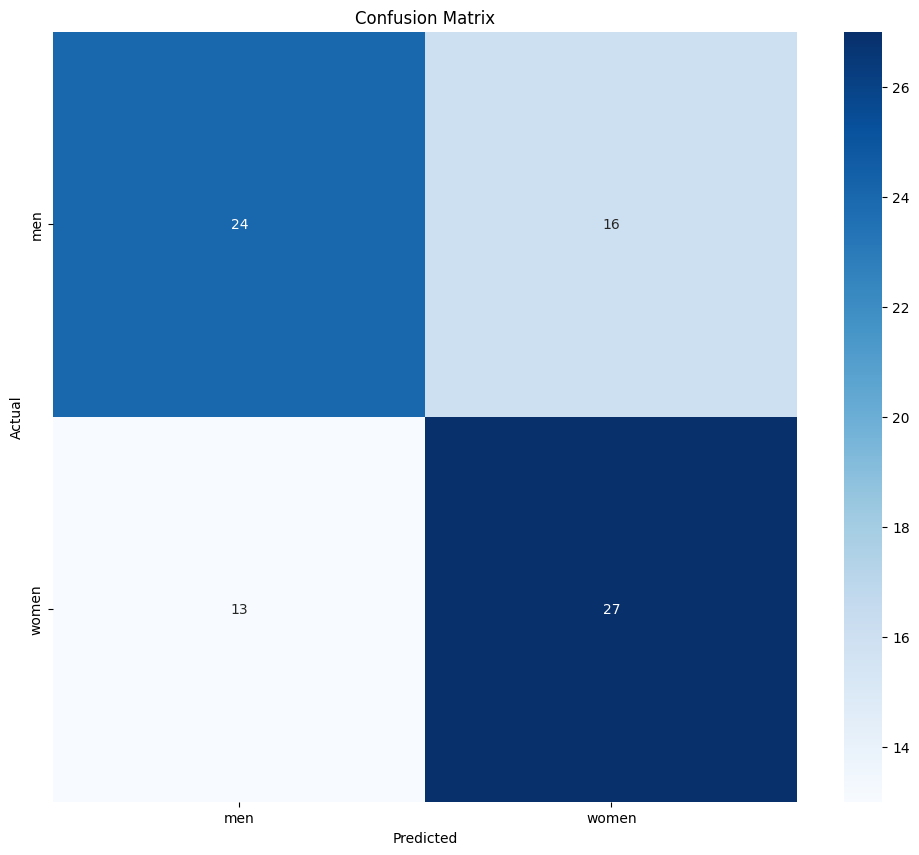

              precision    recall  f1-score   support

         men       0.65      0.60      0.62        40
       women       0.63      0.68      0.65        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80



In [274]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predicted labels for the test data
true_labels = val_gen.classes
predicted_labels = np.argmax(model.predict(val_gen), axis=1)

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices, yticklabels=val_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
class_names = list(val_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

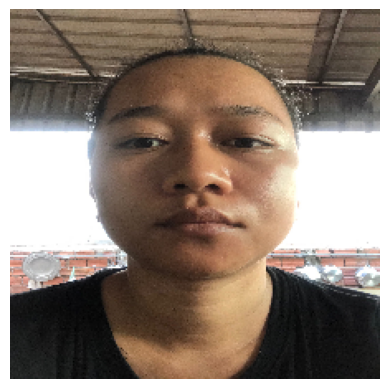

1/1 [==============================] - 0s 55ms/step
True label: women
Predicted label: women


In [276]:
def get_class_string_from_index(index):
   for class_string, class_index in val_gen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_gen)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

Saving model

In [277]:
os.chdir("/content/drive/MyDrive/Gender Classification")
dir = "/content/drive/MyDrive/Gender Classification"
tf.saved_model.save(model, dir)
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
